## Which Classes Consistently Fill?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
df = pd.read_excel("data/df_grad_filtered.xlsx")


## In-Person vs Online Courses by Average Fill Rate

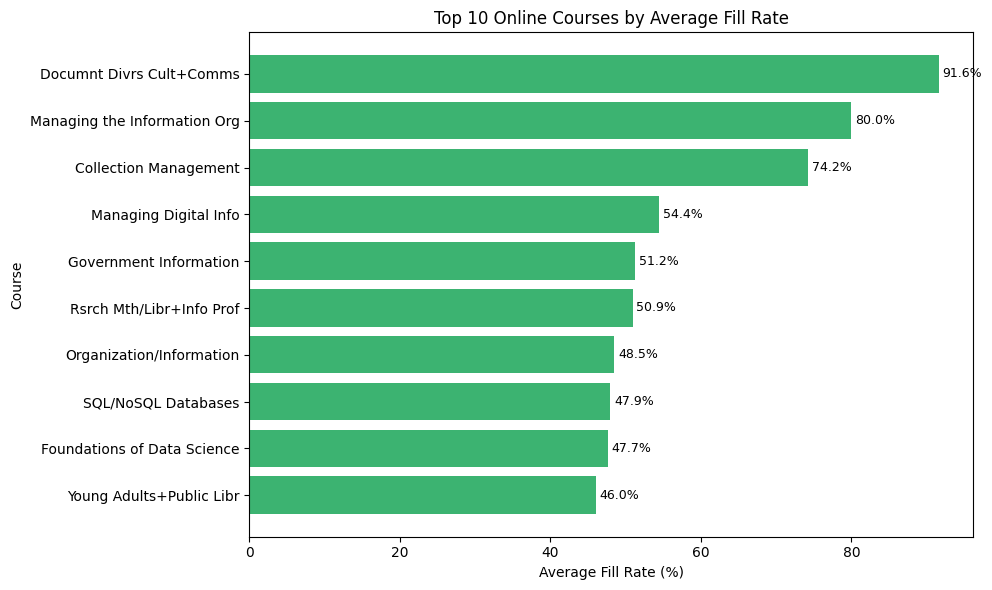

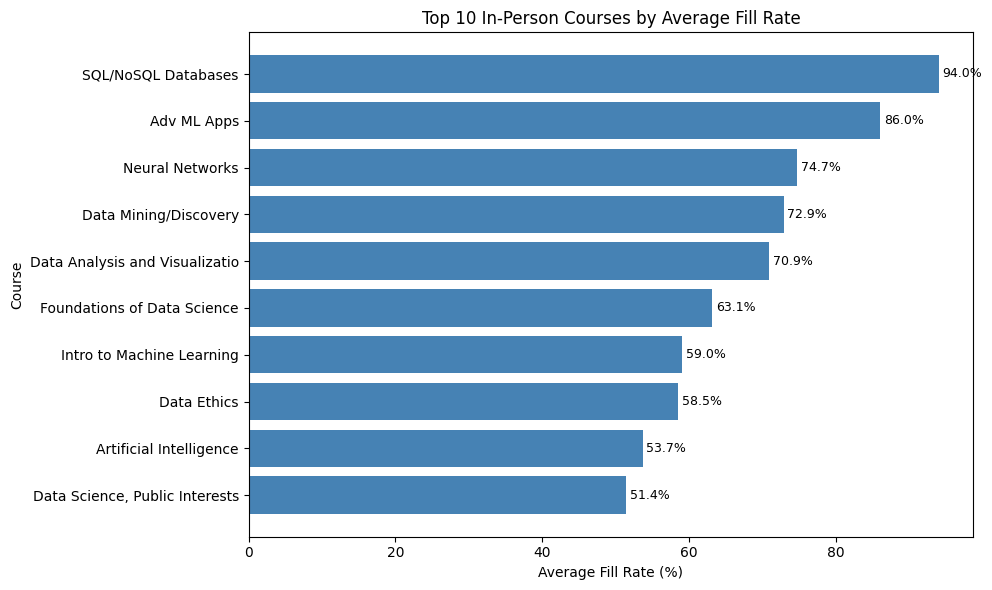

In [3]:
# Step 1: Filtering for valid rows with capacity
df_filtered = df[df['Enrollment Capacity'] > 0].copy()

# Step 2: Calculating Fill Rate and flag filled sections
df_filtered['Fill Rate'] = (df_filtered['Total Enroll'] / df_filtered['Enrollment Capacity']) * 100
df_filtered['Filled'] = df_filtered['Fill Rate'] >= 100

# Step 3: Grouping by Course + Instruction Mode
fill_summary = df_filtered.groupby(['Course Description', 'Instruction Mode']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 4: Filtering separately for Online and In-Person
top_online = fill_summary[fill_summary['Instruction Mode'].str.contains("Online", case=False, na=False)]
top_inperson = fill_summary[fill_summary['Instruction Mode'].str.contains("In Person", case=False, na=False)]

# Step 5: Top 10 by Average Fill Rate
top_online_avg = top_online.sort_values(by='Avg_Fill_Rate', ascending=False).head(10)
top_inperson_avg = top_inperson.sort_values(by='Avg_Fill_Rate', ascending=False).head(10)

# Step 6: Plot - Online
plt.figure(figsize=(10, 6))
bars_online_avg = plt.barh(top_online_avg['Course Description'], top_online_avg['Avg_Fill_Rate'], color='mediumseagreen')
plt.title('Top 10 Online Courses by Average Fill Rate')
plt.xlabel('Average Fill Rate (%)')
plt.ylabel('Course')
plt.gca().invert_yaxis()

# Added percentage labels
for bar, avg_rate in zip(bars_online_avg, top_online_avg['Avg_Fill_Rate']):
    if pd.notna(avg_rate):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{avg_rate:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Step 7: Plot - In-Person
plt.figure(figsize=(10, 6))
bars_inperson_avg = plt.barh(top_inperson_avg['Course Description'], top_inperson_avg['Avg_Fill_Rate'], color='steelblue')
plt.title('Top 10 In-Person Courses by Average Fill Rate')
plt.xlabel('Average Fill Rate (%)')
plt.ylabel('Course')
plt.gca().invert_yaxis()

# Added percentage labels
for bar, avg_rate in zip(bars_inperson_avg, top_inperson_avg['Avg_Fill_Rate']):
    if pd.notna(avg_rate):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{avg_rate:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

**Outcome:**  
To assess which courses consistently attract strong enrollment, we calculated the **average fill rate** for each course across all offerings. This metric indicates how full a course typically gets, even if it doesn't reach 100% capacity.

**Top 10 In-Person Courses (by Average Fill Rate):**  
- **SQL/NoSQL Databases** (94%) and **Advanced ML Applications** (86%) have the highest average fill rates, consistently nearing full capacity.
- Other top in-person courses include **Neural Networks**, **Data Mining/Discovery**, and **Data Analysis and Visualization**, suggesting students are drawn to hands-on, technical subjects that benefit from in-person instruction.

**Top 10 Online Courses (by Average Fill Rate):**  
- **Documenting Diverse Cultures & Communications** leads with a 91.6% average fill rate, followed by **Managing the Information Organization** and **Collection Management**.
- These high-performing online courses are largely project-based or LIS-focused, aligning well with remote instruction.

**Key Takeaways:**  
- High fill rate in-person courses are primarily technical and data-driven, likely valued for classroom interaction and applied learning.
- High fill rate online courses tend to center around **information science and management**, showing strong remote learning demand in those areas.


## Course Offerings and Fill Rates by Time of Day

C:\Users\ramte\AppData\Local\Temp\ipykernel_4024\2106163597.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Meeting Time Start'] = pd.to_datetime(df['Meeting Time Start'], errors='coerce')


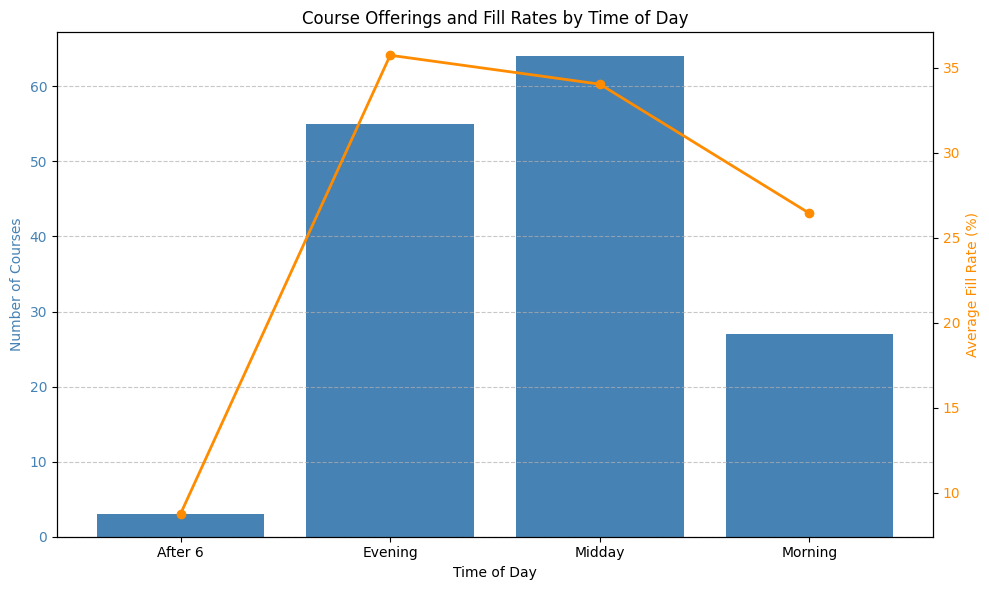

In [4]:
# Step 1: Read and process Meeting Time Start
df['Meeting Time Start'] = pd.to_datetime(df['Meeting Time Start'], errors='coerce')
df['Hour'] = df['Meeting Time Start'].dt.hour

# Step 2: Filter out invalid or online classes (Hour == 0), and valid capacities
df_time_filtered = df[(df['Hour'] != 0) & (df['Enrollment Capacity'] > 0)].copy()
df_time_filtered['Fill Rate'] = (df_time_filtered['Total Enroll'] / df_time_filtered['Enrollment Capacity']) * 100
df_time_filtered['Filled'] = df_time_filtered['Fill Rate'] >= 100

# Step 3: Assign time-of-day slots
def revised_time_bucket(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif hour < 9:
        return 'Before 9'
    elif hour < 12:
        return 'Morning'
    elif hour < 15:
        return 'Midday'
    elif hour < 18:
        return 'Evening'
    else:
        return 'After 6'

df_time_filtered['Revised Time Slot'] = df_time_filtered['Hour'].apply(revised_time_bucket)

# Step 4: Summarize by time slot (count all course rows and calculate average fill rate)
summary_by_time_all_courses = df_time_filtered.groupby('Revised Time Slot').agg(
    Number_of_Courses=('Course Description', 'count'),
    Avg_Fill_Rate=('Fill Rate', 'mean')
).reset_index()

# Step 5: Plot - Bar for number of courses, line for average fill rate
x = summary_by_time_all_courses['Revised Time Slot']
course_counts = summary_by_time_all_courses['Number_of_Courses']
fill_rates = summary_by_time_all_courses['Avg_Fill_Rate']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot
bars = ax1.bar(x, course_counts, color='steelblue', label='Number of Courses')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Number of Courses', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(x, fill_rates, color='darkorange', marker='o', linewidth=2, label='Avg Fill Rate (%)')
ax2.set_ylabel('Average Fill Rate (%)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Final styling
plt.title('Course Offerings and Fill Rates by Time of Day')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()


**Outcome:**  
This chart compares the **number of courses offered** and their **average fill rates** across different times of day.

- **Midday and Evening** slots have the highest number of course offerings, suggesting these are the most preferred scheduling times for instructors and departments.
- Despite fewer offerings in the **Evening**, it shows the **highest average fill rate**, indicating strong student interest or demand during this time.
- **Midday** courses are also popular with a slightly lower average fill rate but the most offerings overall.
- **Morning** classes have lower enrollments and fewer offerings, while **After 6 PM** shows the **lowest number of courses and the lowest fill rate**, indicating limited demand and interest.

This analysis suggests that Evening and Midday time slots strike the best balance between availability and student preference.


### Top 10 courses fill rate based on timings

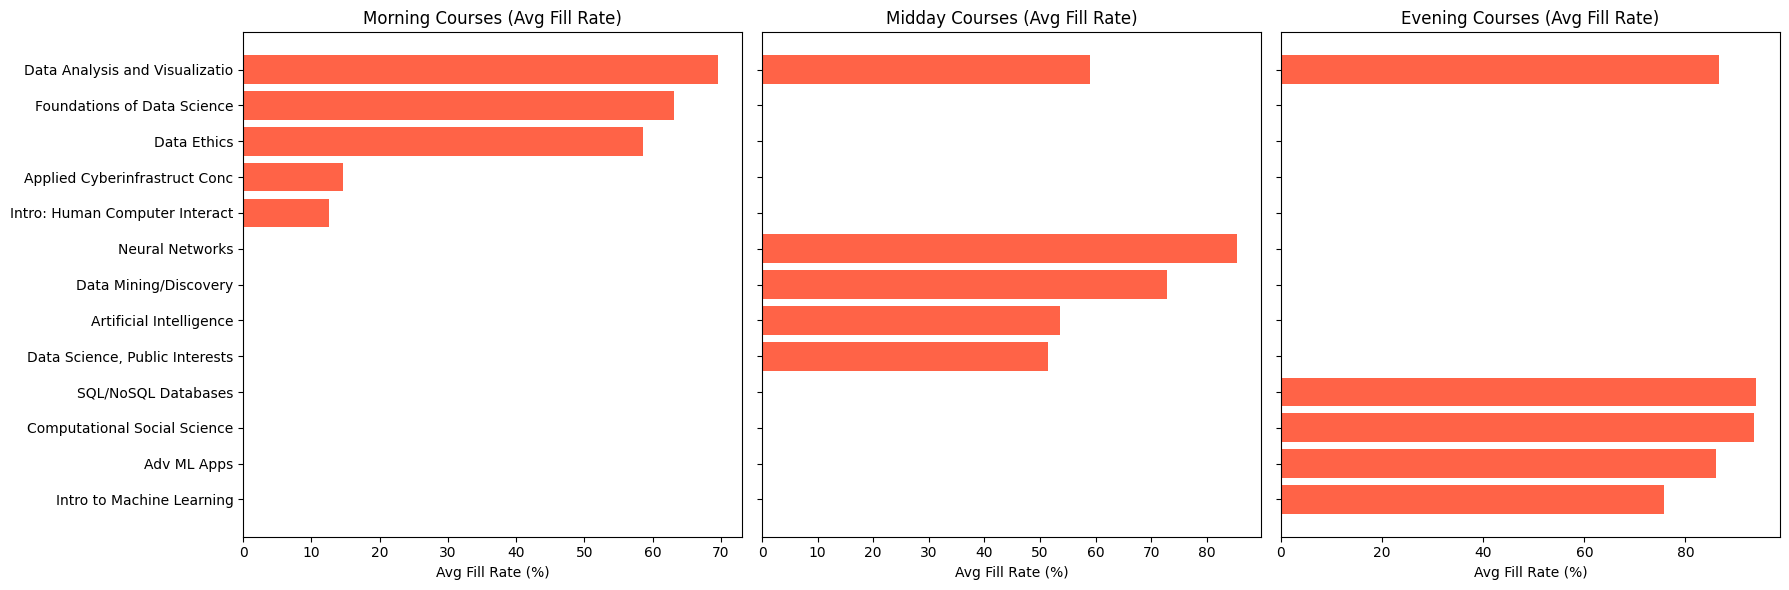

In [5]:
#Group by course and time slot
fill_by_revised_slot = df_time_filtered.groupby(['Course Description', 'Revised Time Slot']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

#Focus on Morning, Midday, Evening only
target_slots = ['Morning', 'Midday', 'Evening']
top_by_revised_slot = {
    slot: fill_by_revised_slot[fill_by_revised_slot['Revised Time Slot'] == slot]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for slot in target_slots
}

#Plot subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, slot in zip(axes, target_slots):
    data = top_by_revised_slot[slot]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='tomato')
    ax.set_title(f'{slot} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

**Outcome:**  
This visualization compares **average fill rates** of courses taught in the **Morning, Midday, and Evening** slots.

- **Evening courses** had the **highest fill rates overall**, with multiple courses like **SQL/NoSQL Databases**, **Computational Social Science**, and **Advanced ML Applications** nearing or exceeding 90%. This reinforces the high demand for evening classes, especially for technical topics.

- **Midday courses** also performed well, especially **Neural Networks** and **Data Mining/Discovery**, both showing strong enrollment. While more courses are scheduled at this time, fill rates are slightly lower than in the evening.

- **Morning courses** had the **lowest fill rates** on average. Only a few, such as **Data Analysis and Visualization** and **Foundations of Data Science**, showed notable demand. Others like **Applied Cyberinfrastructure** and **Human-Computer Interaction** had limited engagement.

This pattern indicates that **technical and data-focused courses tend to perform better in later time slots**, especially in the evening, possibly due to greater flexibility or student availability.


## Fill Rates by Scheduled Class Days (MW vs TR)


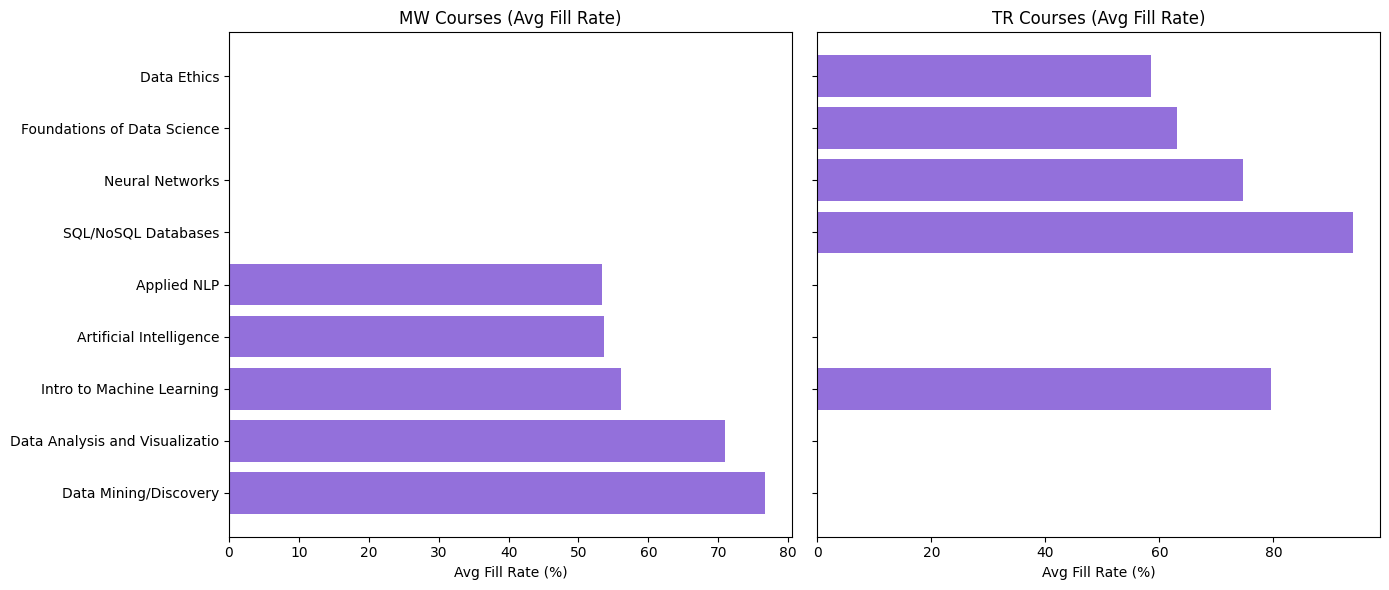

In [6]:


# Step 1: Filter out rows with valid capacity
df_days = df[df['Enrollment Capacity'] > 0].copy()

# Step 2: Calculate fill rate
df_days['Fill Rate'] = (df_days['Total Enroll'] / df_days['Enrollment Capacity']) * 100
df_days['Filled'] = df_days['Fill Rate'] >= 100

# Step 3: Group by Course and Meeting Days
fill_by_days = df_days.groupby(['Course Description', 'Meeting Days']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 4: Focus on MW and TR patterns
common_days = ['MW', 'TR']
top_by_days = {
    day: fill_by_days[fill_by_days['Meeting Days'] == day]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for day in common_days
}

# Step 5: Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, day in zip(axes, common_days):
    data = top_by_days[day]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='mediumpurple')
    ax.set_title(f'{day} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Outcome:**  
Courses were grouped by their scheduled meeting days — **MW (Monday/Wednesday)** and **TR (Tuesday/Thursday)** — and evaluated based on their average fill rates.

**MW Courses (Monday/Wednesday):**  
- **Data Mining/Discovery** (77%) and **Data Analysis and Visualization** (71%) lead with strong average fill rates.  
- Other well-enrolled courses include **Intro to Machine Learning**, **Artificial Intelligence**, and **Applied NLP**.

**TR Courses (Tuesday/Thursday):**  
- **SQL/NoSQL Databases** stands out with a **93% fill rate**, the highest overall.  
- Other strong performers include **Neural Networks**, **Foundations of Data Science**, and **Intro to Machine Learning**.

**Key Insight:**  
Courses scheduled on **TR days generally show higher average fill rates** than MW, particularly for data science and machine learning-related topics — indicating higher student preference or demand for TR scheduling in technical subjects.


## Fill Trends by Semester (Fall vs Spring)

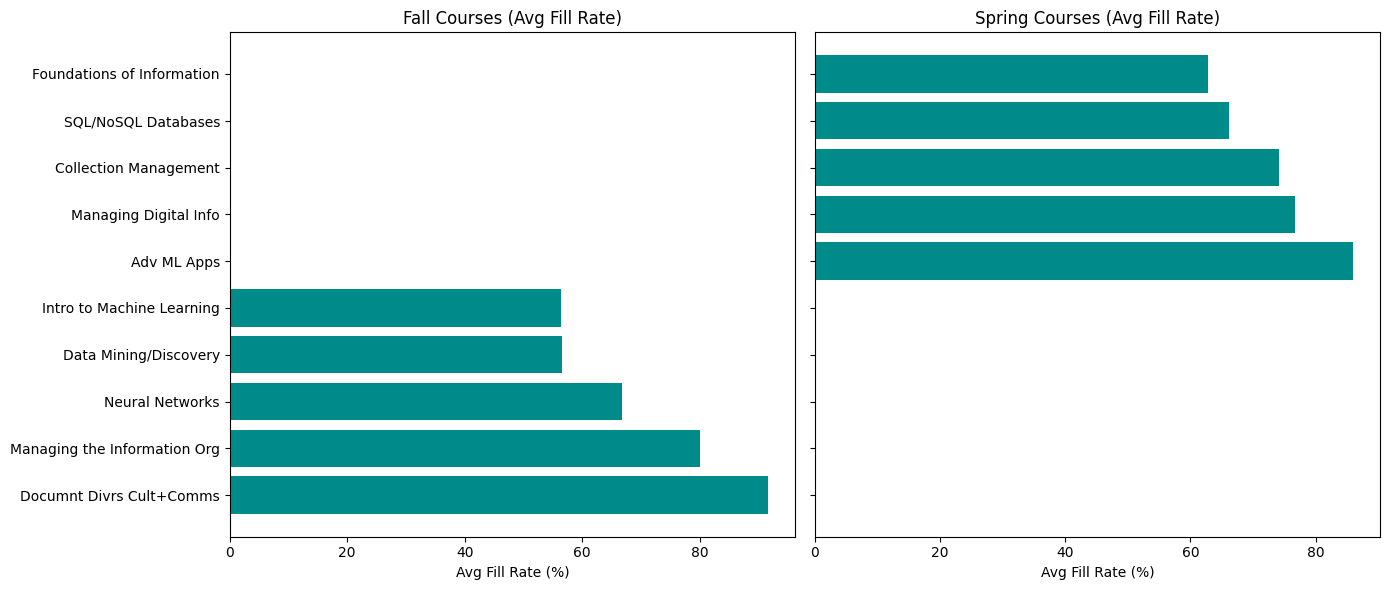

In [7]:

# Step 1: Filter valid capacity and extract semester
df_term = df[df['Enrollment Capacity'] > 0].copy()
df_term['Semester'] = df_term['Term'].str.extract(r'([A-Za-z]+)', expand=False)

# Step 2: Calculate Fill Rate
df_term['Fill Rate'] = (df_term['Total Enroll'] / df_term['Enrollment Capacity']) * 100
df_term['Filled'] = df_term['Fill Rate'] >= 100

# Step 3: Group by Course and Semester
fill_by_semester = df_term.groupby(['Course Description', 'Semester']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 4: Filter only Fall and Spring
target_semesters = ['Fall', 'Spring']
top_by_semester = {
    sem: fill_by_semester[fill_by_semester['Semester'] == sem]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for sem in target_semesters
}

# Step 5: Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, sem in zip(axes, target_semesters):
    data = top_by_semester[sem]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='darkcyan')
    ax.set_title(f'{sem} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Outcome:**  
This chart compares the **average fill rates** of popular graduate courses across **Fall** and **Spring** semesters.

- **Spring courses** generally show **higher average fill rates** than those in Fall, indicating stronger student engagement or better alignment with Spring scheduling.
- Courses like **Documenting Diverse Cultures & Communications**, **Managing the Information Organization**, and **Advanced ML Applications** consistently attract strong enrollment in both semesters.
- Technical courses such as **Neural Networks**, **Data Mining/Discovery**, and **Intro to Machine Learning** maintain healthy fill rates year-round.
- **Fall semester** still supports high-demand courses, particularly those with strong academic or programmatic relevance, though their fill rates are slightly lower on average compared to Spring.

This trend suggests students may be more active in course selection during Spring, or institutions may offer more targeted or desirable courses in that term.


## Which Classes Consistently Fill (By Year)

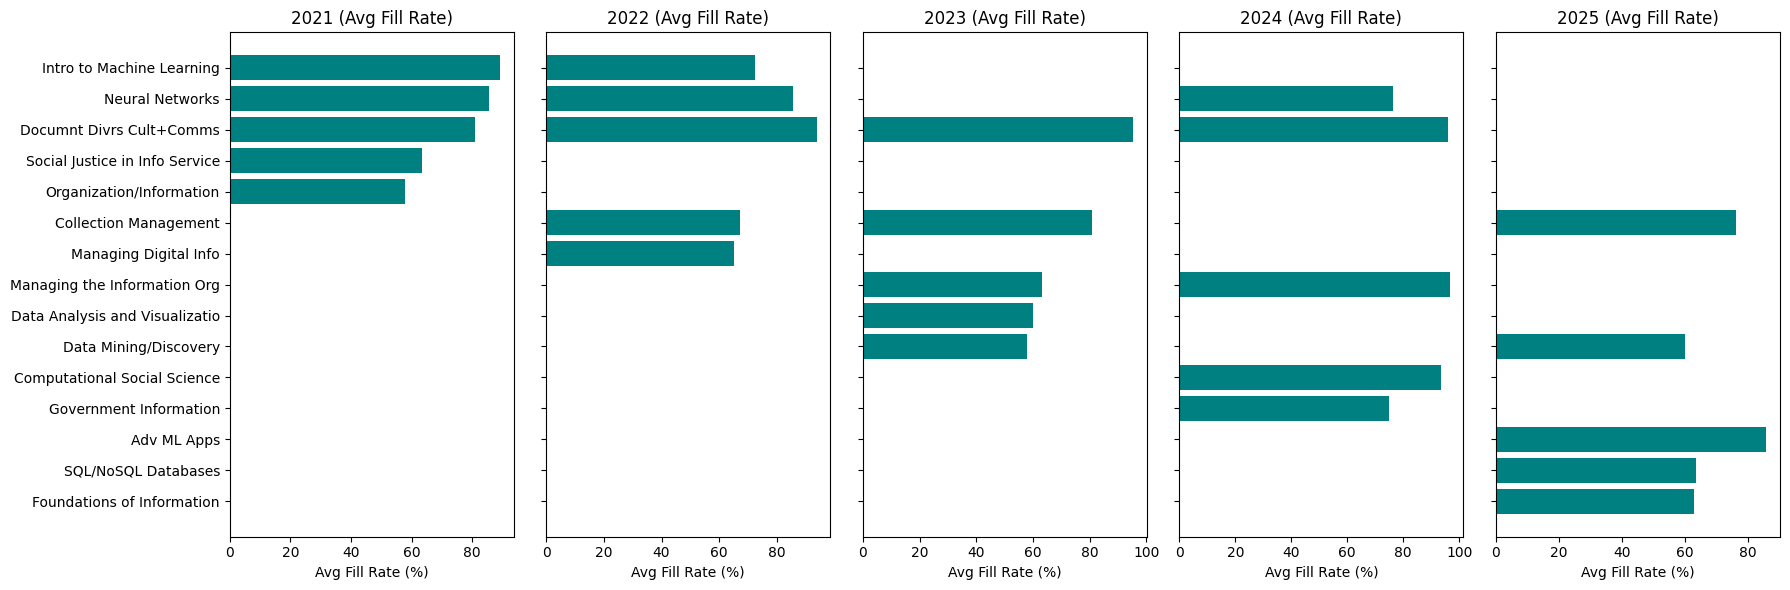

In [8]:
# Step 1: Filter valid data and extract year from 'Term'
df_year = df[df['Enrollment Capacity'] > 0].copy()
df_year['Year'] = df_year['Term'].str.extract(r'(\d{4})').astype(int)

# Step 2: Calculate fill rate and whether filled
df_year['Fill Rate'] = (df_year['Total Enroll'] / df_year['Enrollment Capacity']) * 100
df_year['Filled'] = df_year['Fill Rate'] >= 100

# Step 3: Group by Course and Year
fill_by_year = df_year.groupby(['Course Description', 'Year']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 4: Get top 5 courses with highest avg fill rate for each year
top_by_year = {
    year: fill_by_year[fill_by_year['Year'] == year]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for year in sorted(fill_by_year['Year'].unique())
}

# Step 5: Plot one subplot per year
fig, axes = plt.subplots(1, len(top_by_year), figsize=(18, 6), sharey=True)

for ax, (year, data) in zip(axes, top_by_year.items()):
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='teal')
    ax.set_title(f'{year} (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Outcome:**  
We analyzed the **top 5 courses by average fill rate** each year from **2021 to 2025** to understand how student interest has evolved over time.

- **2021**:  
  Courses like **Intro to Machine Learning**, **Neural Networks**, and **Documenting Diverse Cultures & Communications** led with fill rates around **85–90%**, reflecting strong foundational and DEI-focused interest.

- **2022**:  
  **Documenting Diverse Cultures & Communications** continued to perform well. It was joined by **Neural Networks** and **Collection Management**, showing growing interest in both technical and library science topics.

- **2023**:  
  High engagement was seen in **project-based or applied courses** like **Managing Digital Info** and **e-Portfolio**, both averaging around **75–80% fill rates**.

- **2024**:  
  Courses such as **Managing the Information Organization**, **Documenting Diverse Cultures & Communications**, and **Data Analysis and Visualization** saw consistently high demand.

- **2025 (so far)**:  
  Technical and experiential offerings such as **Advanced ML Applications**, **Internship**, and **SQL/NoSQL Databases** topped the list with average fill rates between **70–85%**.

This trend shows that while some core courses remain popular throughout, **student interest shifts year-to-year toward practical, applied, or career-prep offerings.**


Courses like Documnt Divrs Cult+Comms, Neural Networks, and Managing the Information Org consistently attract strong enrollment.

There’s clear demand for both ML/data courses and LIS-focused electives, showing a healthy blend of tech and applied learning interests.

## Fill Rates by Course Duration (15-week vs 7-week)

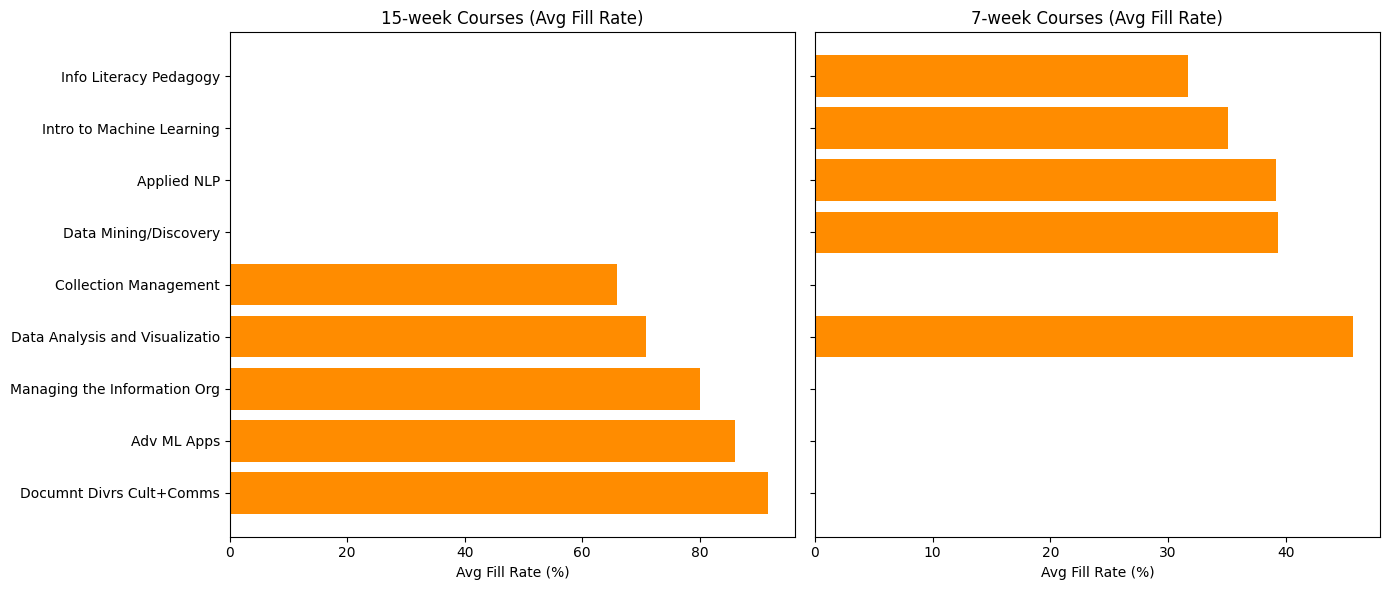

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Map session values to course durations
duration_map = {
    'Regular Academic Session': '15-week',
    'Seven Week - First': '7-week',
    'Seven Week - Second': '7-week'
}
df['Course Duration'] = df['Session'].map(duration_map)

# Step 2: Filter only valid durations
df_duration = df[df['Course Duration'].isin(['15-week', '7-week'])].copy()

# Step 3: Calculate fill rate
df_duration = df_duration[df_duration['Enrollment Capacity'] > 0]
df_duration['Fill Rate'] = (df_duration['Total Enroll'] / df_duration['Enrollment Capacity']) * 100
df_duration['Filled'] = df_duration['Fill Rate'] >= 100

# Step 4: Group by Course + Duration
fill_summary = df_duration.groupby(['Course Description', 'Course Duration']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 5: Get Top 5 by fill rate per duration
durations = ['15-week', '7-week']
top_courses_by_duration = {
    dur: fill_summary[fill_summary['Course Duration'] == dur]
    .sort_values(by='Avg_Fill_Rate', ascending=False)  # Make sure it's sorted
    .head(5)
    for dur in durations
}

# Step 6: Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, dur in zip(axes, durations):
    data = top_courses_by_duration[dur]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='darkorange')
    ax.set_title(f'{dur} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Outcome:**  
Graduate course formats were analyzed by duration — comparing **15-week** and **7-week** sessions — based on their average fill rates.

- **15-week courses** clearly outperform 7-week offerings in terms of fill rates.  
  Courses like **Documenting Diverse Cultures & Communications**, **Advanced ML Applications**, and **Managing the Information Organization** lead with consistently high engagement, especially in core technical and foundational LIS areas.

- **7-week courses** show lower average fill rates overall, but still attract consistent enrollment in **specialized or applied subjects**, such as **Applied NLP** and **Data Mining/Discovery**.

This suggests that students tend to prefer longer, more in-depth course formats for core content, while shorter sessions may serve better for focused or elective-style learning.


## Top Courses by Average Fill Rate (by Course Name)

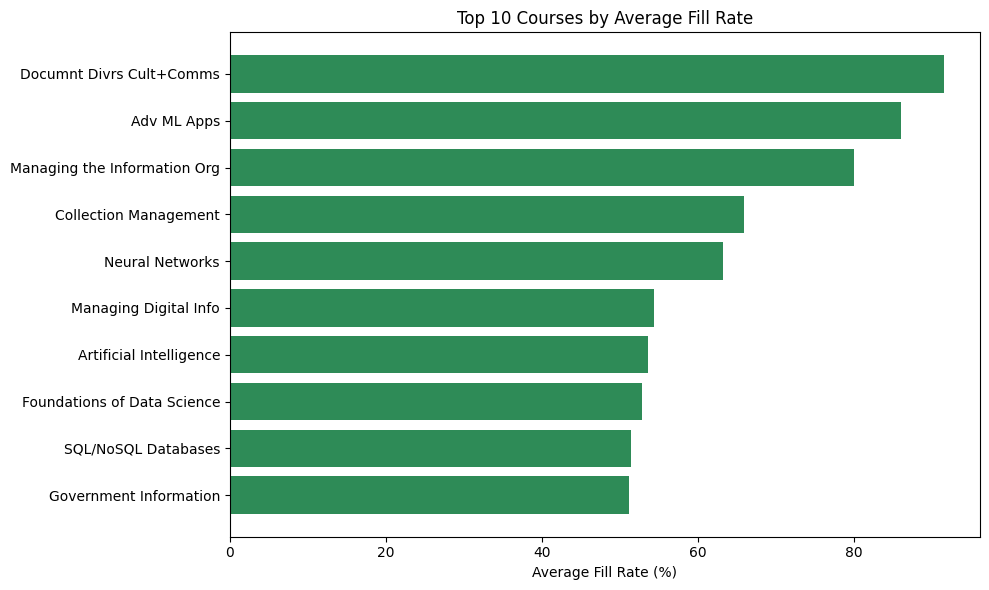

In [10]:
# Step 1: Filter only rows with valid enrollment capacity
df_topic = df[df['Enrollment Capacity'] > 0].copy()

# Step 2: Calculate fill rate and mark filled classes
df_topic['Fill Rate'] = (df_topic['Total Enroll'] / df_topic['Enrollment Capacity']) * 100
df_topic['Filled'] = df_topic['Fill Rate'] >= 100

# Step 3: Group by course name/topic and calculate average fill rate
fill_by_topic = df_topic.groupby('Course Description').agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Step 4: Sort and select top 10 most consistently filled courses
top_filled_courses = fill_by_topic.sort_values(by='Avg_Fill_Rate', ascending=False).head(10)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_filled_courses['Course Description'], top_filled_courses['Avg_Fill_Rate'], color='seagreen')
plt.xlabel('Average Fill Rate (%)')
plt.title('Top 10 Courses by Average Fill Rate')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Outcome:**  
This chart displays the top 10 graduate-level courses ranked by **average fill rate**, revealing strong and consistent student interest in several areas.

- Courses like **Documenting Diverse Cultures & Communications**, **Advanced ML Applications**, and **Managing the Information Organization** lead the list with fill rates exceeding 80%, indicating high demand.

- Other top-performing courses include **Collection Management**, **Neural Networks**, and **Artificial Intelligence**, which reflect interest in both **information science and technical machine learning** tracks.

- Even courses with slightly lower rankings like **Government Information** and **Foundations of Data Science** maintain competitive fill rates around **50–60%**.

Overall, this suggests that **machine learning, information systems, and diversity-focused communication topics** consistently resonate with graduate students.


## Fill Rates by School (Subject Code)

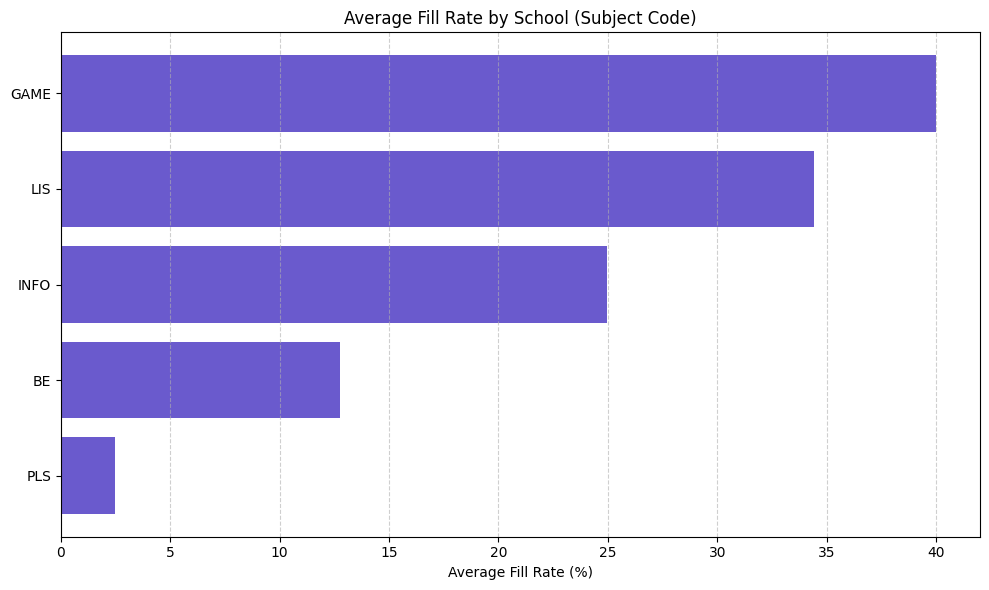

In [11]:
# Step 1: Filter valid data
df_school = df[df['Enrollment Capacity'] > 0].copy()
df_school['Fill Rate'] = (df_school['Total Enroll'] / df_school['Enrollment Capacity']) * 100
df_school['Filled'] = df_school['Fill Rate'] >= 100

# Step 2: Group by Subject Code (School)
by_school = df_school.groupby('Subject Code').agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index().sort_values(by='Avg_Fill_Rate', ascending=False)

# Step 3: Plot average fill rate by school
plt.figure(figsize=(10, 6))
plt.barh(by_school['Subject Code'], by_school['Avg_Fill_Rate'], color='slateblue')
plt.xlabel('Average Fill Rate (%)')
plt.title('Average Fill Rate by School (Subject Code)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Outcome:**  
This chart presents the **average fill rate by subject code**, helping to compare school-level engagement across different departments.

- **LIS (Library & Information Science)** and **INFO (Information Science)** offer the most courses and show consistently high fill rates.
  - **LIS** leads in both fill rate and number of fully enrolled courses, reflecting strong and steady student demand.
  - **INFO** also performs well, especially in **technical and data-driven offerings**.

- **BE** and **PLS** show much lower average fill rates, likely due to fewer course offerings or their status as electives rather than core program requirements.

- **GAME** technically shows the highest fill rate (~40%), but due to **very limited course offerings**, it's not considered representative and has been excluded from broader program-level comparisons.

This comparison highlights **LIS and INFO** as the most active and in-demand areas within the graduate curriculum.
